# ECM-MPT Data Analysis

 The following notebook will go through prediction analysis for the Extracellular-Matrix Multiple Particle Tracking (ECM-MPT) study of pup age in P14, P21, P28, and P35 datasets.


## Table of Contents


  [1.   Load Data](#1.---Load-Data)<br />
  [2.   Analysis](#2.---Analysis)<br />
  [3.   Modelling](#3.---Modelling)<br />
  [4.   Evaluate Results](4.---Evaluate-Results)<br />

---

## 1.   Load Data

Loading feature dataset from AWS NanceLab Bucket: p14, p21, p28, data are present on mckenna.data/08_06_19_MPT_age_dependence while p35 data is present on mckenna.data/07_16_19_MPT_ECM_breakdown. This bucket is only available through access with Nance lab.

There are 15 total videos from each age group. Names of each dataset downloaded are present on dwnld_list.txt.

In [506]:
# libraries used
import boto3
import diff_classifier.aws as aws
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as pl
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

import xgboost as xgb
from xgboost import cv

import shap

In [2]:
dwnld_list = []
source_bucket = 'dash2927.data'
source_folder = 'ECM_work'
keyword = ['40nm', 'NT_brain_2']
s3 = boto3.resource('s3')
bucket = s3.Bucket(source_bucket)

for object in bucket.objects.all():
    folder, filename = ('/'.join(object.key.split("/")
                                 [:-1]), object.key.split("/")[-1])
    # only look in remote_folder and if any keyword(s) math filename
    if folder in source_folder and any(k in filename for k in ([keyword]*isinstance(keyword, str) or keyword)):
        dwnld_list.append(s3.Object(object.bucket_name, object.key))

dwnld_list = [filename.key for filename in dwnld_list if 'features' in filename.key]

In [3]:
dwnld_list

['ECM_work/features_NT_brain_2_slice_1_vid_1.csv',
 'ECM_work/features_NT_brain_2_slice_1_vid_2.csv',
 'ECM_work/features_NT_brain_2_slice_1_vid_3.csv',
 'ECM_work/features_NT_brain_2_slice_1_vid_4.csv',
 'ECM_work/features_NT_brain_2_slice_1_vid_5.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_1.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_2.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_3.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_4.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_5.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_1.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_2.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_3.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_4.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_5.csv',
 'ECM_work/features_P14_40nm_s1_v1.csv',
 'ECM_work/features_P14_40nm_s1_v2.csv',
 'ECM_work/features_P14_40nm_s1_v3.csv',
 'ECM_work/features_P14_40nm_s1_v4.csv',
 'ECM_work/features_P14_40nm_s1_v5.csv',
 'ECM_work/features_P14_40nm_s2_v1.csv',
 'ECM_work/features_P14_40nm_s2_v2.csv',
 'ECM_work/features_P14_40nm_s2_v3.csv',
 'ECM_work/features_P14_40nm_s2_v4.csv',
 'ECM_work/features_P14_40nm_s2_v5.csv',
 'ECM_work/features_P14_40nm_s3_v1.csv',
 'ECM_work/features_P14_40nm_s3_v2.csv',
 'ECM_work/features_P14_40nm_s3_v3.csv',
 'ECM_work/features_P14_40nm_s3_v4.csv',
 'ECM_work/features_P14_40nm_s3_v5.csv',
 'ECM_work/features_P21_40nm_s1_v1.csv',
 'ECM_work/features_P21_40nm_s1_v2.csv',
 'ECM_work/features_P21_40nm_s1_v3.csv',
 'ECM_work/features_P21_40nm_s1_v4.csv',
 'ECM_work/features_P21_40nm_s1_v5.csv',
 'ECM_work/features_P21_40nm_s2_v1.csv',
 'ECM_work/features_P21_40nm_s2_v2.csv',
 'ECM_work/features_P21_40nm_s2_v3.csv',
 'ECM_work/features_P21_40nm_s2_v4.csv',
 'ECM_work/features_P21_40nm_s2_v5.csv',
 'ECM_work/features_P21_40nm_s3_v1.csv',
 'ECM_work/features_P21_40nm_s3_v2.csv',
 'ECM_work/features_P21_40nm_s3_v3.csv',
 'ECM_work/features_P21_40nm_s3_v4.csv',
 'ECM_work/features_P21_40nm_s3_v5.csv',
 'ECM_work/features_P28_40nm_s1_v1.csv',
 'ECM_work/features_P28_40nm_s1_v2.csv',
 'ECM_work/features_P28_40nm_s1_v3.csv',
 'ECM_work/features_P28_40nm_s1_v4.csv',
 'ECM_work/features_P28_40nm_s1_v5.csv',
 'ECM_work/features_P28_40nm_s2_v1.csv',
 'ECM_work/features_P28_40nm_s2_v2.csv',
 'ECM_work/features_P28_40nm_s2_v3.csv',
 'ECM_work/features_P28_40nm_s2_v4.csv',
 'ECM_work/features_P28_40nm_s2_v5.csv',
 'ECM_work/features_P28_40nm_s3_v1.csv',
 'ECM_work/features_P28_40nm_s3_v2.csv',
 'ECM_work/features_P28_40nm_s3_v3.csv',
 'ECM_work/features_P28_40nm_s3_v4.csv',
 'ECM_work/features_P28_40nm_s3_v5.csv']

In [4]:
cnt = 0
for dwnld_file in dwnld_list:
    folder, filename = (dwnld_file.split("/")[0], dwnld_file.split("/")[-1])
    try:
        aws.download_s3(dwnld_file, filename, bucket_name=source_bucket)
        fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
        print('{} size: {}'.format(filename, fstats.shape))
        if 'P14' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[14], index=fstats.index)
        elif 'P21' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[21], index=fstats.index)
        elif 'P28' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[28], index=fstats.index)
        elif 'NT_brain_2' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[35], index=fstats.index)
        else:
            print('Error, no target')
        fstats['Video Number'] = pd.Series(fstats.shape[0]*[cnt], index=fstats.index)
        cnt += 1
        if cnt == 1:
            fstats_tot = fstats
        else:
            fstats_tot = fstats_tot.append(fstats, ignore_index=True)
    except:
            print('Skipped!: {}'.format(filename))
    os.remove(f'./{filename}')

features_NT_brain_2_slice_1_vid_1.csv size: (416, 91)
features_NT_brain_2_slice_1_vid_2.csv size: (833, 91)
features_NT_brain_2_slice_1_vid_3.csv size: (1017, 91)
features_NT_brain_2_slice_1_vid_4.csv size: (878, 91)
features_NT_brain_2_slice_1_vid_5.csv size: (467, 91)
features_NT_brain_2_slice_2_vid_1.csv size: (2488, 91)
features_NT_brain_2_slice_2_vid_2.csv size: (2322, 91)
features_NT_brain_2_slice_2_vid_3.csv size: (1735, 91)
features_NT_brain_2_slice_2_vid_4.csv size: (1650, 91)
features_NT_brain_2_slice_2_vid_5.csv size: (2100, 91)
features_NT_brain_2_slice_3_vid_1.csv size: (562, 91)
features_NT_brain_2_slice_3_vid_2.csv size: (853, 91)
features_NT_brain_2_slice_3_vid_3.csv size: (817, 91)
features_NT_brain_2_slice_3_vid_4.csv size: (598, 91)
features_NT_brain_2_slice_3_vid_5.csv size: (1062, 91)
features_P14_40nm_s1_v1.csv size: (793, 91)
features_P14_40nm_s1_v2.csv size: (1356, 91)
features_P14_40nm_s1_v3.csv size: (519, 91)
features_P14_40nm_s1_v4.csv size: (140, 91)
featur

## 2.   Analysis

The following columns are present within the downloaded datasets:

In [5]:
fstats_tot.columns

Index(['Track_ID', 'alpha', 'D_fit', 'kurtosis', 'asymmetry1', 'asymmetry2',
       'asymmetry3', 'AR', 'elongation', 'boundedness', 'fractal_dim',
       'trappedness', 'efficiency', 'straightness', 'MSD_ratio', 'frames', 'X',
       'Y', 'Quality', 'Mean_Intensity', 'SN_Ratio', 'Deff1', 'Deff2',
       'angle_mean', 'angle_mag_mean', 'angle_var', 'convex_hull',
       'convex_hull_norm', 'dist_tot', 'dist_net', 'progression', 'Mean alpha',
       'Std alpha', 'Mean D_fit', 'Std D_fit', 'Mean kurtosis', 'Std kurtosis',
       'Mean asymmetry1', 'Std asymmetry1', 'Mean asymmetry2',
       'Std asymmetry2', 'Mean asymmetry3', 'Std asymmetry3', 'Mean AR',
       'Std AR', 'Mean elongation', 'Std elongation', 'Mean boundedness',
       'Std boundedness', 'Mean fractal_dim', 'Std fractal_dim',
       'Mean trappedness', 'Std trappedness', 'Mean efficiency',
       'Std efficiency', 'Mean straightness', 'Std straightness',
       'Mean MSD_ratio', 'Std MSD_ratio', 'Mean frames', 'Std frames

Many of these features are not useful for prediction or have data which may negatively impact classification. The following features and the target feature are defined in the following cell. We also remove any datapoints that are empty or infinite:

In [6]:
fstats_tot
features = [
    'alpha', 
    'D_fit', 
    'kurtosis', 
    'asymmetry1', 
    'asymmetry2',
    'asymmetry3', 
    'AR', 
    'elongation', 
    'boundedness', 
    'fractal_dim',
    'trappedness', 
    'efficiency', 
    'straightness', 
    'MSD_ratio', 
    'frames',   
    'Deff1', 
    'Deff2',
    'angle_mean', 
    'angle_mag_mean', 
    'angle_var', 
    'dist_tot', 
    'dist_net', 
    'progression', 
    'Mean alpha',
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',  
]

target = 'age'           # prediction target (y)

ecm = fstats_tot
ecm = ecm[~ecm.isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points

In [7]:
# Showing a piece of our data:
ecm.head()

,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,...,Mean convex_hull_norm,Std convex_hull_norm,Mean dist_tot,Std dist_tot,Mean dist_net,Std dist_net,Mean progression,Std progression,age,Video Number
0,0.0,0.445227,16.493781,5.457711,0.900742,0.161642,0.301680,2.104323,0.524788,0.040769,...,0.0,0.0,53446.037923,39383.730785,2193.565956,17.904650,0.065281,0.040573,35,0
1,1.0,0.107756,0.316246,3.334612,0.071551,0.760212,0.009322,1.213024,0.175614,0.096920,...,0.0,0.0,69929.668778,50752.744606,1793.547419,1.447172,0.053308,0.044553,35,0
2,2.0,0.046968,0.440548,2.587983,0.054303,0.788683,0.007003,1.087747,0.080668,0.098123,...,0.0,0.0,69929.668778,50752.744606,1793.547419,1.447172,0.053308,0.044553,35,0
3,3.0,1.759901,2.452218,2.516403,0.984714,0.062057,0.494242,3.654338,0.726353,0.105210,...,0.0,0.0,53446.037923,39383.730785,2193.565956,17.904650,0.065281,0.040573,35,0
4,4.0,0.438945,8.270880,2.176721,0.997136,0.026778,0.596387,5.244316,0.809317,0.227229,...,0.0,0.0,53446.037923,39383.730785,2193.565956,17.904650,0.065281,0.040573,35,0


Before prediction, it is required to balance data. As shown, The current dataset is highly imbalance with most datapoints belonging to P21 and P35 categories. The dataset is reduced using random sampling of each target category.

In [8]:
ecm_14 = ecm[ecm[target] == 14]
ecm_21 = ecm[ecm[target] == 21]
ecm_28 = ecm[ecm[target] == 28]
ecm_35 = ecm[ecm[target] == 35]
print(f"Ratio before data balance (P14:P21:P28:P35) = {len(ecm_14)}:{len(ecm_21)}:{len(ecm_28)}:{len(ecm_35)}")
ecm_list = [ecm_14, ecm_21, ecm_28, ecm_35]
for i in range(len(ecm_list)):
    ratio = 6000/len(ecm_list[i])
    ecm_list[i] = ecm_list[i].sample(frac=ratio, random_state=1)
print(f"Ratio before after balance (P14:P21:P28:P35) = {len(ecm_list[0])}:{len(ecm_list[1])}:{len(ecm_list[2])}:{len(ecm_list[3])}")
bal_ecm = pd.concat(ecm_list)

Ratio before data balance (P14:P21:P28:P35) = 6416:20665:6194:17169
Ratio before after balance (P14:P21:P28:P35) = 6000:6000:6000:6000


## 3.   Modelling

The model used for this study is an extreme gradient boosting (XGBoost) decision tree which is a boosted decision tree. This model was used due to its past results within competitions and research.

In [9]:
# Using checkerboard binning for data split:
def checkerboard(size):
    rows = int(size/2)
    checks = list(range(0, size*size, size+1))
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(2*i + (size+1)*j)
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(size*size - 1 - (2*i + (size+1)*j))
    checks.sort()
    return checks

In [10]:
bins = list(range(0, 2048+1, 256))
bal_ecm['binx'] = pd.cut(bal_ecm.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
bal_ecm['biny'] = pd.cut(bal_ecm.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
bal_ecm['bins'] = 8*bal_ecm['binx'].astype(np.int8) + bal_ecm['biny'].astype(np.int8)
bal_ecm = bal_ecm[np.isfinite(bal_ecm['bins'])]
bal_ecm['bins'] = bal_ecm['bins'].astype(int)

cols = bal_ecm.columns.tolist()
cols = cols[-3:] + cols[:-3]
bal_ecm = bal_ecm[cols]

In [203]:
le = preprocessing.LabelEncoder()
X_train = bal_ecm[~bal_ecm.bins.isin(checkerboard(8))].reset_index()
X_test_val =  bal_ecm[bal_ecm.bins.isin(checkerboard(8))].reset_index()
y_train = le.fit_transform(X_train[target])
X_val, X_test = train_test_split(X_test_val, test_size=0.5, random_state=123)
y_test = le.fit_transform(X_test[target])
y_val = le.fit_transform(X_val[target])
dtrain = xgb.DMatrix(X_train[new_feat], label=y_train)
dtest = xgb.DMatrix(X_test[new_feat], label=y_test)
dval = xgb.DMatrix(X_val[new_feat], label=y_val)

In [356]:
param = {'max_depth': 7,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 4,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8}

In [367]:
watchlist = [(dval, 'eval'), (dtrain, 'train')]
num_round = 10
bst = xgb.train(param, dtrain, num_round, watchlist)

######
label = dtest.get_label()
ypred1 = bst.predict(dtest)
# by default, we predict using all the trees
pred = [np.where(x == np.max(x))[0][0] for x in ypred1]
print("Accuracy:",metrics.accuracy_score(y_test, pred))

[0]	eval-merror:0.549112	train-merror:0.425043
[1]	eval-merror:0.50419	train-merror:0.378553
[2]	eval-merror:0.495977	train-merror:0.345902
[3]	eval-merror:0.487764	train-merror:0.340515
[4]	eval-merror:0.477372	train-merror:0.338278
[5]	eval-merror:0.472679	train-merror:0.335792
[6]	eval-merror:0.46765	train-merror:0.336455
[7]	eval-merror:0.466477	train-merror:0.3343
[8]	eval-merror:0.463627	train-merror:0.321207
[9]	eval-merror:0.457761	train-merror:0.323941
Accuracy: 0.5374560080442433


In [368]:
results = X_test[features]
results['predicted'] = pred
results['actual'] = y_test

/root/anaconda3/envs/david/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/root/anaconda3/envs/david/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## 4.   Evaluate Results

In [369]:
print('0 == {}'.format(le.inverse_transform([0])))
print('1 == {}'.format(le.inverse_transform([1])))
print('2 == {}'.format(le.inverse_transform([2])))
print('3 == {}'.format(le.inverse_transform([3])))
class_names = ['P14', 'P21', 'P28', 'P35']

0 == [14]
1 == [21]
2 == [28]
3 == [35]


In [370]:
class_results = classification_report(y_test, pred, digits=4, target_names = ['P14', 'P21', 'P28', 'P35'])
print(str(class_results))

              precision    recall  f1-score   support

         P14     0.6330    0.7852    0.7009      1485
         P21     0.5155    0.3751    0.4342      1549
         P28     0.4044    0.3169    0.3553      1461
         P35     0.5380    0.6773    0.5997      1472

    accuracy                         0.5375      5967
   macro avg     0.5227    0.5386    0.5225      5967
weighted avg     0.5231    0.5375    0.5221      5967



In [520]:
confusion_matrix(y_test, pred)

array([[1166,  129,  148,   42],
       [ 302,  581,  271,  395],
       [ 303,  276,  463,  419],
       [  71,  141,  263,  997]])

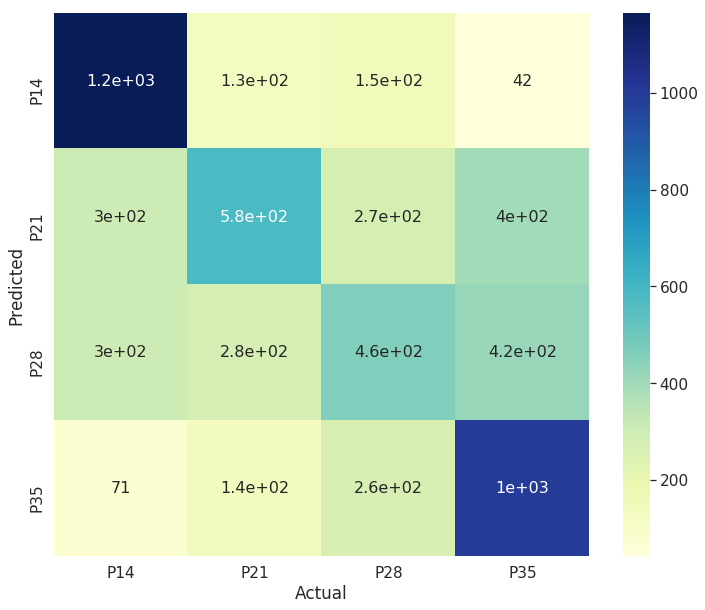

In [550]:
confusion_matrix(y_test, pred)
pl.figure(figsize=(12,10))
cm_array = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Actual', ylabel='Predicted')

pl.show()

* Training trajectories for each age
* Weighted score at the bottom
* 

In [40]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test[features])

In [41]:
top_feat = ['Mean Deff1', 'Mean fractal_dim', 'Mean D_fit', 'Mean MSD_ratio', 'Mean kurtosis', 'Mean Deff2']

In [42]:
%matplotlib inline

In [404]:
import matplotlib.pyplot as pl
from matplotlib import colors as plt_colors

In [411]:
colors = ['#999999', '#e5bf62', '#7995e9', '#a64ca6']
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])

In [417]:
class_inds

array([0, 3, 2, 1])

In [412]:
np.array(colors)[class_inds]

array(['#999999', '#a64ca6', '#7995e9', '#e5bf62'], dtype='<U7')

In [559]:
# sn.reset_orig() # Reset matplot lib to no longer use seaborn

/root/anaconda3/envs/david/lib/python3.7/site-packages/matplotlib-3.0.3-py3.7-linux-x86_64.egg/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/root/anaconda3/envs/david/lib/python3.7/site-packages/matplotlib-3.0.3-py3.7-linux-x86_64.egg/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


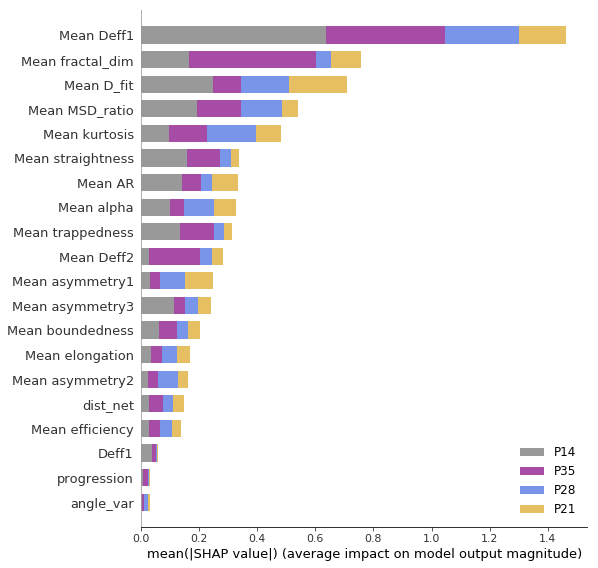

In [560]:
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), title='Total SHAP Values', color=cmap)

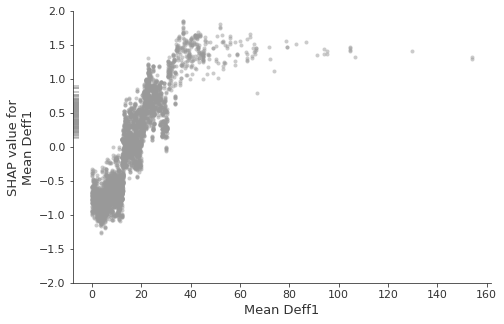

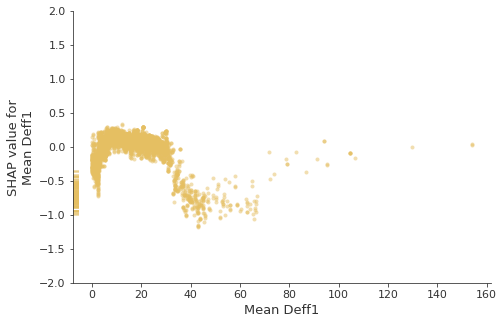

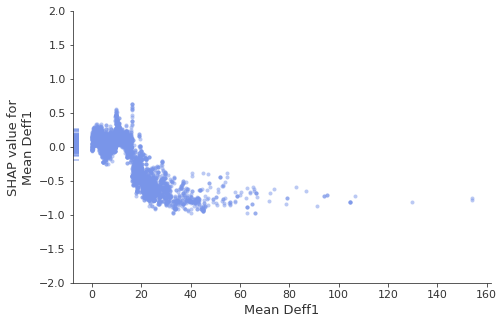

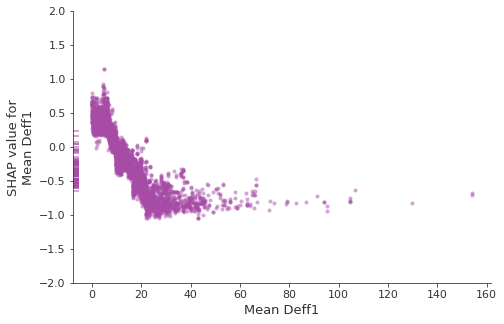

In [566]:
pl.ioff()
%matplotlib inline


figsize = (7.5, 5)
bottom = -2.0
top = 2.0
for i in range(len(shap_values)):
    fig = pl.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(bottom, top)
    shap.dependence_plot("Mean Deff1", shap_values[i], X_test[features], interaction_index = None, color=colors[i], alpha=0.5, ax=ax)

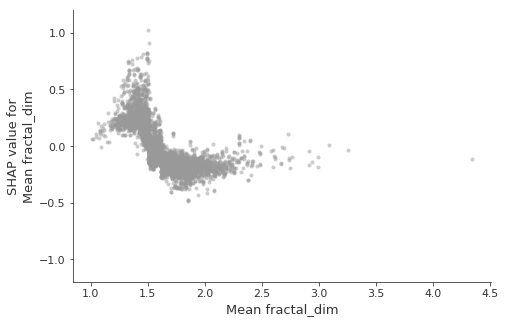

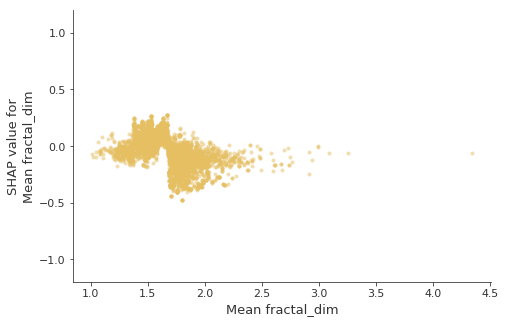

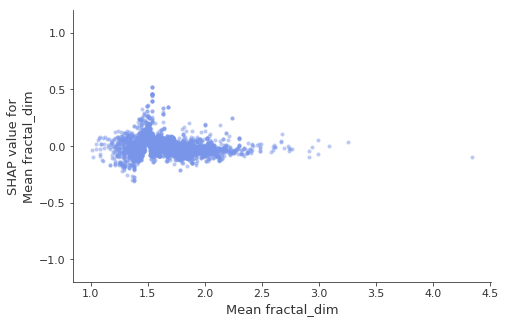

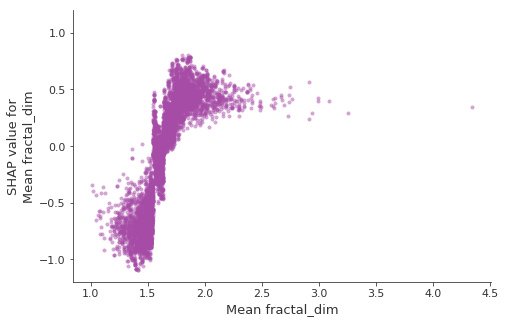

In [567]:
figsize = (7.5, 5)
bottom = -1.2
top = 1.2
for i in range(len(shap_values)):
    fig = pl.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(bottom, top)
    shap.dependence_plot("Mean fractal_dim", shap_values[i], X_test[features], interaction_index = None, color=colors[i], alpha=0.5, ax=ax)

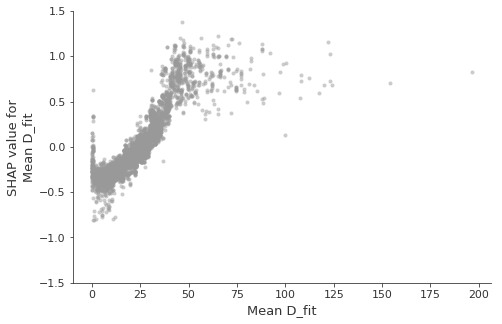

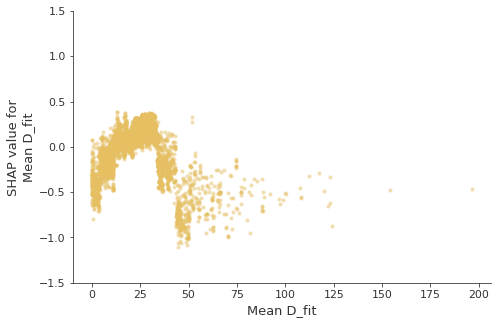

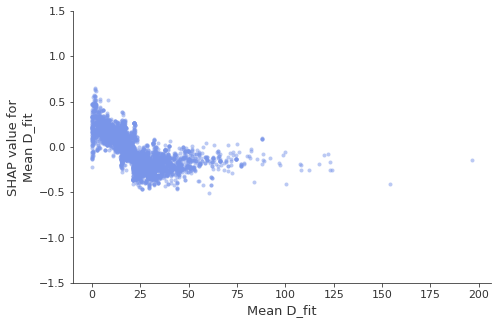

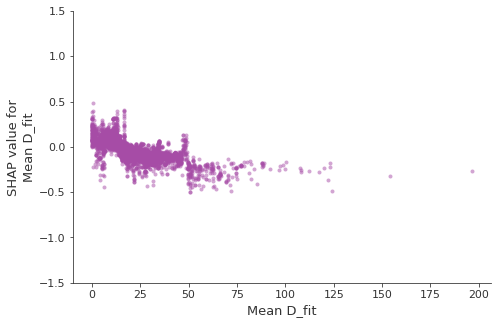

In [568]:
figsize = (7.5, 5)
bottom = -1.5
top = 1.5
for i in range(len(shap_values)):
    fig = pl.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(bottom, top)
    shap.dependence_plot("Mean D_fit", shap_values[i], X_test[features], interaction_index = None, color=colors[i], alpha=0.5, ax=ax)

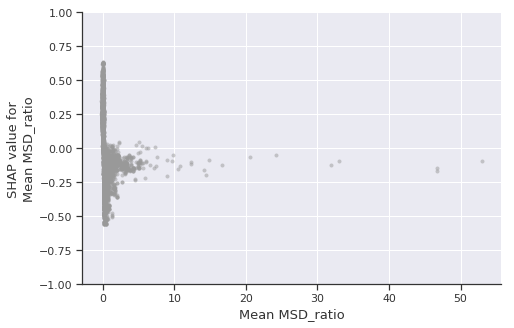

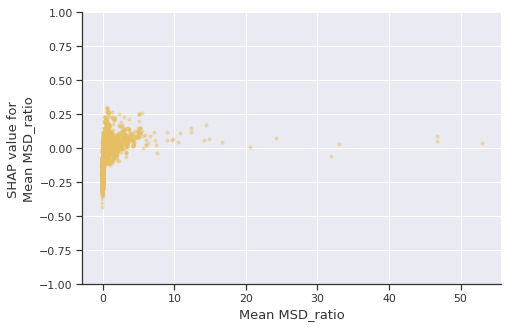

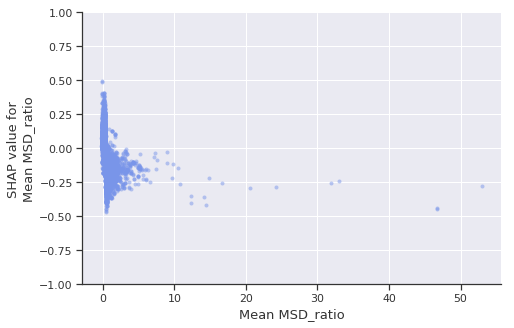

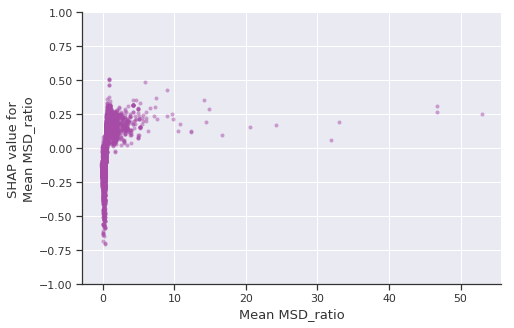

In [555]:
figsize = (7.5, 5)
bottom = -1.0
top = 1.0
for i in range(len(shap_values)):
    fig = pl.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(bottom, top)
    shap.dependence_plot("Mean MSD_ratio", shap_values[i], X_test[features], interaction_index = None, color=colors[i], alpha=0.5, ax=ax)

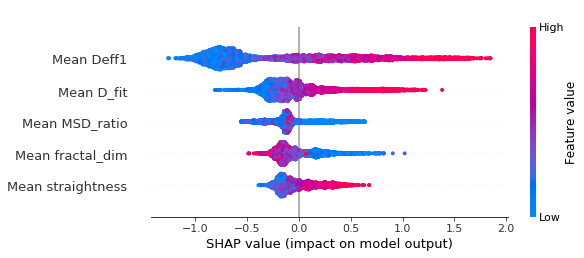

In [562]:
shap.summary_plot(shap_values[0], X_test[features], max_display=5, class_names = class_names, title = 'SHAP Value for P14')

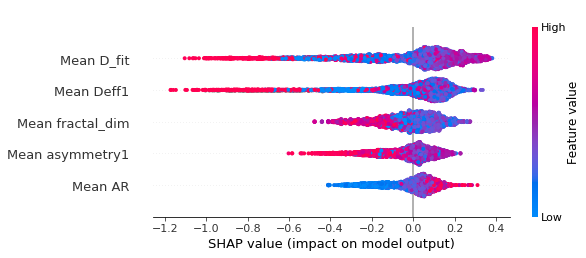

In [563]:
shap.summary_plot(shap_values[1], X_test[features], max_display=5, class_names = class_names, title = 'SHAP Value for P21')

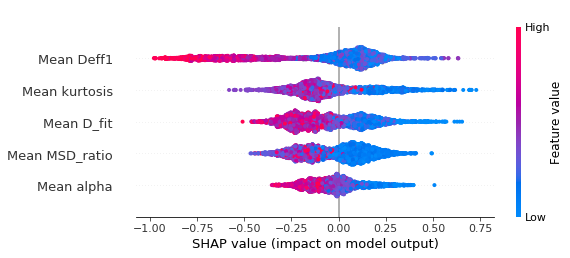

In [564]:
shap.summary_plot(shap_values[2], X_test[features], max_display=5, class_names = class_names, title='SHAP Value for P28')

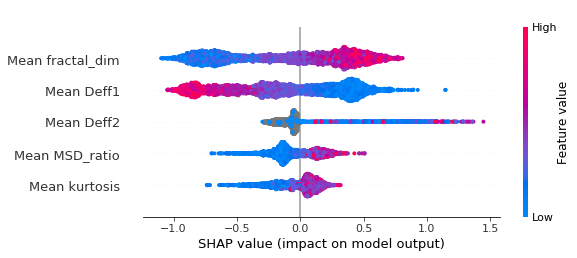

In [565]:
shap.summary_plot(shap_values[3], X_test[features], max_display=5, class_names=class_names, title='SHAP Value for P35')

In [390]:
from modules import anim_plot
from importlib import reload
reload(anim_plot)

_ = anim_plot.rotate_3d(results, top_feat[0], top_feat[1], top_feat[2])
_ = anim_plot.rotate_3d(results, top_feat[0], top_feat[2], top_feat[3])
_ = anim_plot.rotate_3d(results, top_feat[1], top_feat[2], top_feat[3])

MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.
MovieWriter imagemagick unavailable. Trying to use pillow instead.


In [106]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

In [108]:
rot_animation = animation.FuncAnimation(fig, rotate, init_func=init, frames=np.arange(0,362,2), interval=50, repeat=True)

NameError: name 'rotate' is not defined

In [371]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train[features], y_train, eval_set=[(X_val[features],y_val)], eval_metric='mlogloss')

[0]	validation_0-mlogloss:1.35641
[1]	validation_0-mlogloss:1.33075
[2]	validation_0-mlogloss:1.30869
[3]	validation_0-mlogloss:1.2886
[4]	validation_0-mlogloss:1.27071
[5]	validation_0-mlogloss:1.25489
[6]	validation_0-mlogloss:1.24051
[7]	validation_0-mlogloss:1.22821
[8]	validation_0-mlogloss:1.21673
[9]	validation_0-mlogloss:1.20634
[10]	validation_0-mlogloss:1.19701
[11]	validation_0-mlogloss:1.18735
[12]	validation_0-mlogloss:1.17945
[13]	validation_0-mlogloss:1.1723
[14]	validation_0-mlogloss:1.16559
[15]	validation_0-mlogloss:1.16051
[16]	validation_0-mlogloss:1.15571
[17]	validation_0-mlogloss:1.1509
[18]	validation_0-mlogloss:1.14612
[19]	validation_0-mlogloss:1.14174
[20]	validation_0-mlogloss:1.13737
[21]	validation_0-mlogloss:1.13383
[22]	validation_0-mlogloss:1.13004
[23]	validation_0-mlogloss:1.12698
[24]	validation_0-mlogloss:1.12416
[25]	validation_0-mlogloss:1.12119
[26]	validation_0-mlogloss:1.11814
[27]	validation_0-mlogloss:1.11547
[28]	validation_0-mlogloss:1.1134

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [372]:
pred2 = model.predict(X_test[features])

In [373]:
print("Accuracy:", metrics.accuracy_score(y_test, pred2))

Accuracy: 0.5285738226914698


In [374]:
print(model.feature_importances_)

[0.01575044 0.00988575 0.00727114 0.00630781 0.         0.
 0.         0.         0.01396107 0.00090939 0.         0.00821161
 0.0015085  0.         0.         0.0177965  0.         0.00841611
 0.0113392  0.01241675 0.01167816 0.02084191 0.02121906 0.03201523
 0.04493757 0.04685833 0.03457359 0.04283031 0.03968466 0.04265575
 0.0360451  0.03011213 0.09099513 0.06546869 0.0219856  0.0628343
 0.05317503 0.13495371 0.05336156]


In [375]:
np.array(model.feature_importances_ > .078)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False,  True, False])

In [377]:
np.array(features)[np.array(model.feature_importances_ == 0)]

array(['asymmetry2', 'asymmetry3', 'AR', 'elongation', 'trappedness',
       'MSD_ratio', 'frames', 'Deff2'], dtype='<U17')

In [376]:
# Feature search: 

thresh = np.arange(0,.1,.002)
best_acc = -1
best_thresh = -1
model2 = XGBClassifier()
for t in thresh:
    print(f"Using thresh = {t} ",end = '| ')
    new_feat = np.array(features)[np.array(model.feature_importances_ > t)]
    model2.fit(X_train[new_feat], y_train, verbose=False, eval_set=[(X_val[new_feat],y_val)], eval_metric='mlogloss')
    pred3 = model2.predict(X_test[new_feat])
    acc = metrics.accuracy_score(y_test, pred3)
    print(f"Accuracy = {acc} ",end = '| ')
    if acc > best_acc:
        best_thresh = t
        best_acc = acc
    print(f"Best accuracy = {best_acc}, Best threshold = {best_thresh}")
print(f"Features used:\n{np.array(features)[np.array(model.feature_importances_ > best_thresh)]}")

Using thresh = 0.0 | Accuracy = 0.5285738226914698 | Best accuracy = 0.5285738226914698, Best threshold = 0.0
Using thresh = 0.002 | Accuracy = 0.5299145299145299 | Best accuracy = 0.5299145299145299, Best threshold = 0.002
Using thresh = 0.004 | Accuracy = 0.5299145299145299 | Best accuracy = 0.5299145299145299, Best threshold = 0.002
Using thresh = 0.006 | Accuracy = 0.5299145299145299 | Best accuracy = 0.5299145299145299, Best threshold = 0.002
Using thresh = 0.008 | Accuracy = 0.5292441763029998 | Best accuracy = 0.5299145299145299, Best threshold = 0.002
Using thresh = 0.01 | Accuracy = 0.5299145299145299 | Best accuracy = 0.5299145299145299, Best threshold = 0.002
Using thresh = 0.012 | Accuracy = 0.5295793531087649 | Best accuracy = 0.5299145299145299, Best threshold = 0.002
Using thresh = 0.014 | Accuracy = 0.5272331154684096 | Best accuracy = 0.5299145299145299, Best threshold = 0.002
Using thresh = 0.016 | Accuracy = 0.5277358806770571 | Best accuracy = 0.5299145299145299, Be

In [443]:
dict_importance =  dict(zip(np.array(features), model.feature_importances_))

In [445]:
dict_importance

{'alpha': 0.015750438,
 'D_fit': 0.009885745,
 'kurtosis': 0.0072711436,
 'asymmetry1': 0.0063078078,
 'asymmetry2': 0.0,
 'asymmetry3': 0.0,
 'AR': 0.0,
 'elongation': 0.0,
 'boundedness': 0.013961074,
 'fractal_dim': 0.0009093893,
 'trappedness': 0.0,
 'efficiency': 0.008211613,
 'straightness': 0.001508499,
 'MSD_ratio': 0.0,
 'frames': 0.0,
 'Deff1': 0.017796498,
 'Deff2': 0.0,
 'angle_mean': 0.008416113,
 'angle_mag_mean': 0.011339197,
 'angle_var': 0.012416749,
 'dist_tot': 0.011678165,
 'dist_net': 0.02084191,
 'progression': 0.021219064,
 'Mean alpha': 0.032015227,
 'Mean D_fit': 0.044937566,
 'Mean kurtosis': 0.046858333,
 'Mean asymmetry1': 0.03457359,
 'Mean asymmetry2': 0.04283031,
 'Mean asymmetry3': 0.039684657,
 'Mean AR': 0.04265575,
 'Mean elongation': 0.036045097,
 'Mean boundedness': 0.03011213,
 'Mean fractal_dim': 0.09099513,
 'Mean trappedness': 0.06546869,
 'Mean efficiency': 0.021985603,
 'Mean straightness': 0.0628343,
 'Mean MSD_ratio': 0.053175032,
 'Mean Def

In [444]:
sorted(dict_importance, key=dict_importance.get, reverse=True)[:5]

['Mean Deff1',
 'Mean fractal_dim',
 'Mean trappedness',
 'Mean straightness',
 'Mean Deff2']

In [202]:
new_feat = np.array(features)[np.array(model.feature_importances_ > best_thresh)]
model2.fit(X_train[new_feat], y_train, verbose=False, eval_set=[(X_val[new_feat],y_val)], eval_metric='mlogloss')
pred3 = model2.predict(X_test[new_feat])
acc = metrics.accuracy_score(y_test, pred3)
print("Accuracy:",metrics.accuracy_score(y_test, pred3))

Accuracy: 0.534104239986593


In [192]:
acc

0.5230434053963465

In [170]:
rot_animation = animation.FuncAnimation(fig, rotate, init_func=init, frames=np.arange(0,362,2),interval=None)

NameError: name 'rotate' is not defined

In [379]:
from IPython.display import HTML

In [451]:
xgb.plot.shap()

AttributeError: module 'xgboost' has no attribute 'plot'

In [384]:
HTML('rotation_MeanDeff1_MeanD_fit_MeanMSD_ratio.html')

In [387]:
!brew install imagemagick

Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - imagemagick

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




* [Done] Try analysis without P21 data
* [Done] Try combining
* [Done] Do a video of 3d plots
* [Done] SHAP summitive
* [Done] SHAP bounds
* Keep wrking on random forest


* While waiting for review
* Pot. change algorithm to rand forest


* On exp end, Mike will get adult dataset


* Make methods: how data was split, how training eval test, SHAP, algorithm, link to github
* Wrk on discusion (why, limitations, etc)
* Results

* Nxt chkpt: January 17th 